# Init

In [ ]:
import sys
import gym
import numpy as np
import random
from collections import defaultdict

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls drive/'My Drive'/RL/gym-foo

gym_foo  gym_foo.egg-info  setup.py


In [ ]:
!pip install -e drive/'My Drive'/RL/gym-foo/

Obtaining file:///content/drive/My%20Drive/RL/gym-foo
  Found existing installation: gym-foo 0.0.1
    Can't uninstall 'gym-foo'. No files were found to uninstall.
  Running setup.py develop for gym-foo


In [ ]:
# !pip install gym_foo

In [ ]:
import gym_foo

In [ ]:
# env = gym.make('Blackjack-v0')
env = gym.make('gym_foo:foo-v0')

In [ ]:
#help(env) #this will explain the env

In [ ]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(3)


In [ ]:
#Random Policy:
for i_episode in range(5):
    state = env.reset()
    while True:
        print(state) 
        action = env.action_space.sample() # takes random action from environment's action space
        state, reward, done, info = env.step(action) # OpenAI gym gives feedback in this tuple form : state,reward,if_done?,other relevant info
        if done:
            print('Game has ended! Your Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(12, 9, False)
Game has ended! Your Reward:  1.0
You won :)

(13, 4, False)
Game has ended! Your Reward:  0.0
You lost :(

(17, 6, False)
Game has ended! Your Reward:  1.0
You won :)

(20, 4, False)
Game has ended! Your Reward:  -2.0
You lost :(

(21, 10, True)
Game has ended! Your Reward:  -1.0
You lost :(



# Monte Carlo Control (Task 2.1)

Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

### Добавим double


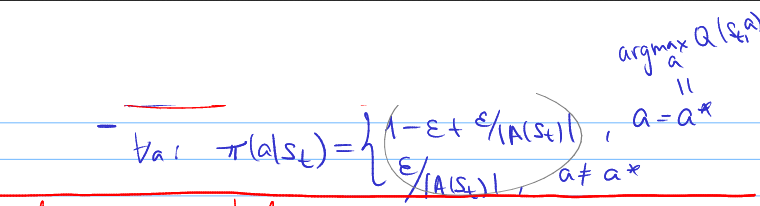

In [ ]:
# Epsilon-мягкая
def get_probs(Q_s, epsilon, nA): #nA is no. of actions in the action space
    # a <> a*
    policy_s = np.ones(nA) * epsilon / nA # array из nA элементов (в нашем случае из 2х)
    # a == a*
    a_star = np.argmax(Q_s)
    policy_s[a_star] = 1 - epsilon + (epsilon / nA)
    return policy_s

Аналогично прошлому, только со стратегией случайного выбора с вер-ми

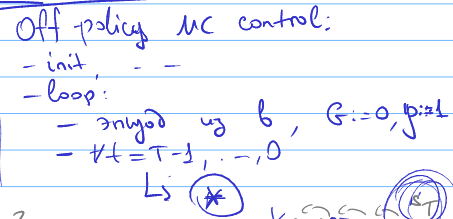

In [ ]:
def generate_episode_from_Q(bj_env, Q, epsilon, nA):
    # generates an episode from following the epsilon-greedy policy
    episode = []
    state = bj_env.reset()
    while True:
        if state in Q:
            probas = get_probs(Q[state], epsilon, nA)
            # print("\n probas: \n")
            # print(probas)
            # выбор одного из nA случайных действий (в нашем случае из 2х)
            action = np.random.choice(np.arange(nA), p=probas)
        else:
            action = bj_env.action_space.sample() #random init
          
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [ ]:
nA = env.action_space.n
Q = defaultdict(lambda: np.zeros(nA))
eps=.9


for i in range(5):
    print(generate_episode_from_Q(env, Q, eps, nA))

[((16, 10, False), 0, -1.0)]
[((13, 1, False), 2, -2.0)]
[((14, 10, False), 0, -1.0)]
[((8, 8, False), 1, -1.0)]
[((13, 10, False), 1, -1.0)]


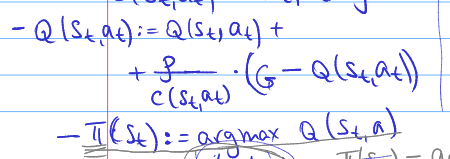

In [ ]:
def average_reward(env, Q, nA, n_episodes=100_000):

    rewards = 0
    epsilon = 0
    for _ in range(n_episodes):
        rewards += generate_episode_from_Q(env, Q, epsilon, nA)[-1][-1]
    return rewards / n_episodes
    #print('\n', rewards / n_episodes, '\n') #return

In [ ]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    rewards_list = []
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        
        if i_episode % 10000 == 0:
            rewards_list.append(average_reward(env, Q, nA))
        # update the action-value function estimate using the episode
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        # update Q
        for i, state in enumerate(states):
            Q_curr = Q[state][actions[i]] 
            Q[state][actions[i]] = Q_curr + alpha*(sum(rewards[i:]) - Q_curr)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q, rewards_list

In [ ]:
rewards_cnt_task1 = [
    [-0.13125, -0.10665, -0.10077, -0.0921, -0.08081, -0.08551, -0.07142, -0.07837, -0.07455, -0.06697],  
    [-0.12495, -0.11194, -0.0869, -0.09483, -0.09264, -0.08645, -0.07394, -0.07748, -0.07177, -0.06833],  
    [-0.11841, -0.1113, -0.09851, -0.09121, -0.09301, -0.08508, -0.06884, -0.07095, -0.07591, -0.07295],  
    [-0.11227, -0.11329, -0.10623, -0.09253, -0.08661, -0.0839, -0.0822, -0.08868, -0.07102, -0.05898],  
    [-0.13324, -0.11214, -0.09603, -0.10549, -0.09239, -0.09189, -0.08301, -0.08219, -0.07284, -0.08093],  
    [-0.11062, -0.10298, -0.101, -0.0928, -0.09322, -0.08245, -0.09112, -0.08135, -0.07669, -0.07168]
    ]

In [ ]:
# obtain the estimated optimal policy and action-value function
from tqdm.notebook import  tqdm

rewards_cnt = []

for j in tqdm(range(0, 11, 2)):
    policy, Q, rewards = mc_control(env, 100_000, 0.015, gamma= j / 10)
    rewards_cnt.append(rewards)

Episode 100000/100000.


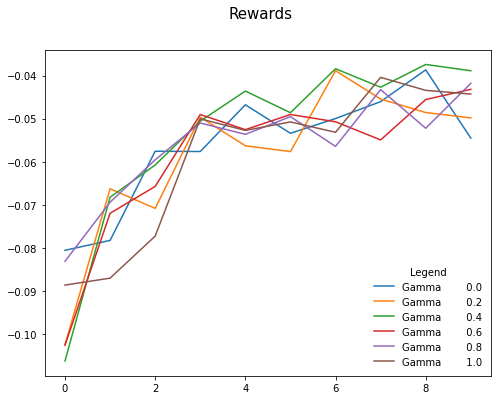

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(8, 6))
fig.suptitle('Rewards', fontsize=15)
for i in range(len(rewards_cnt)):
    #print(i)
    ax.plot(rewards_cnt[i], label="Gamma {:10.1f}".format((i*2)/10))
plt.legend(loc="lower right", title="Legend", frameon=False)
plt.show()

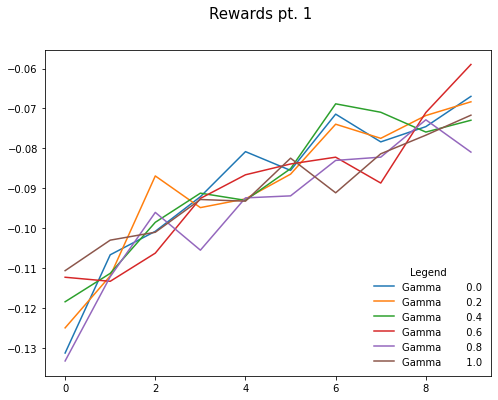

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(8, 6))
fig.suptitle('Rewards pt. 1', fontsize=15)
for i in range(len(rewards_cnt_task1)):
    #print(i)
    ax.plot(rewards_cnt_task1[i], label="Gamma {:10.1f}".format((i*2)/10))
plt.legend(loc="lower right", title="Legend", frameon=False)
plt.show()

#Q-learning (Task 2.2)

### Добавим double

In [ ]:
def epsilon_greedy(Q, state, nA, eps):
    """Selects epsilon-greedy action for supplied state.
    
    Params
    ======
        Q (dictionary): action-value function
        state (int): current state
        nA (int): number actions in the environment
        eps (float): epsilon
    """
    if random.random() > eps: # select greedy action with probability epsilon
        return np.argmax(Q[state])
    else:                     # otherwise, select an action randomly
        return random.choice(np.arange(env.action_space.n))
        

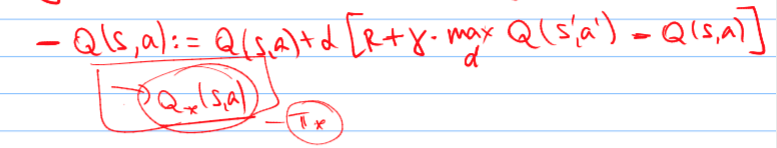

In [ ]:
def update_Q_sarsamax(alpha, gamma, Q, state, action, R, next_state=None):
    """Returns updated Q-value for the most recent experience."""
    Q_current = Q[state][action]  # estimate in Q-table (for current state, action pair)
    if next_state is not None:
        maxQ_next = np.max(Q[next_state])
    else: 
        maxQ_next = 0  # value of next state 

    Qsa_new = Q_current + alpha * (R + gamma * maxQ_next - Q_current) # get updated value 
    return Qsa_new

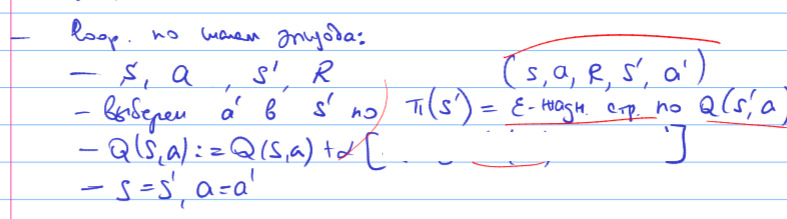

In [ ]:
def generate_episode_Q_sarsamax(bj_env, Q, epsilon, nA, alpha, gamma):
    # generates an episode from following the epsilon-greedy policy
    episode = []
    score = 0                                              # initialize score
    state = bj_env.reset()
    while True:
        # eps greedy
        if random.random() > epsilon:
            action = np.argmax(Q[state])
        else:
            action = random.choice(np.arange(env.action_space.n))

        next_state, reward, done, info = bj_env.step(action)  # take action A, observe R, S'
        episode.append((state, action, reward))
        
        # Q update
        score += reward                                       # add reward to agent's score
        Q[state][action] = update_Q_sarsamax(alpha, gamma, Q, \
                                             state, action, reward, next_state)        
        state = next_state                                 # S <- S'
        if done: # note: no A <- A'
            break
    return episode, Q 

In [ ]:
def generate_episode_Q_sarsamax_test(bj_env, Q, nA, alpha, gamma):
    # generates an episode from following the epsilon-greedy policy
    episode = []
    score = 0
    state = bj_env.reset()
    while True:
        action = np.argmax(Q[state])

        next_state, reward, done, info = bj_env.step(action)  # take action A, observe R, S'
        episode.append((state, action, reward))
      
        score += reward                                       # add reward to agent's score
        Q[state][action] = update_Q_sarsamax(alpha, gamma, Q, \
                                             state, action, reward, next_state)        
        state = next_state          

        if done: 
            break
    return episode

In [ ]:
def average_reward_q(env, Q, nA, alpha, gamma, n_episodes=100_000):

    rewards = 0
    epsilon = 0
    for _ in range(n_episodes):
        rewards += generate_episode_Q_sarsamax_test(env, Q, nA, alpha, gamma)[-1][-1]
    return rewards / n_episodes

In [ ]:
def q_learning(env, num_episodes, alpha, gamma=1.0, epsmin=0.01):
    """Q-Learning - TD Control
    
    Params
    ======
        num_episodes (int): number of episodes to run the algorithm
        alpha (float): learning rate
        gamma (float): discount factor
        plot_every (int): number of episodes to use when calculating average score
    """
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    
    rewards_list = []
    rew = 0
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        score = 0                                              # initialize score
        state = env.reset()                                    # start episode
        eps = max(1.0 / i_episode ,epsmin)                                 # set value of epsilon
        
        # для каждого шага в эпизоде
        episode, Q = generate_episode_Q_sarsamax(env, Q, eps, nA, alpha, gamma)
        
      
        rew += episode[-1][-1]
        if i_episode % 10_000 == 0:
            rewards_list.append(average_reward_q(env, Q, nA, alpha, gamma))
    
    print(rew / num_episodes)

    return Q, rewards_list

In [ ]:
# Q, rewards = q_learning(env, 100_000, 0.015)

Episode 100000/100000-0.16158


In [ ]:
from tqdm.notebook import  tqdm

rewards_sarsa = []

for j in tqdm(range(0, 11, 2)):
    Q, rewards = q_learning(env, 100_000, 0.015, gamma= j / 10)
    rewards_sarsa.append(rewards)

Episode 100000/100000-0.05272
Episode 100000/100000-0.04733
Episode 100000/100000-0.06153
Episode 100000/100000-0.06618
Episode 100000/100000-0.06855
Episode 100000/100000-0.07435



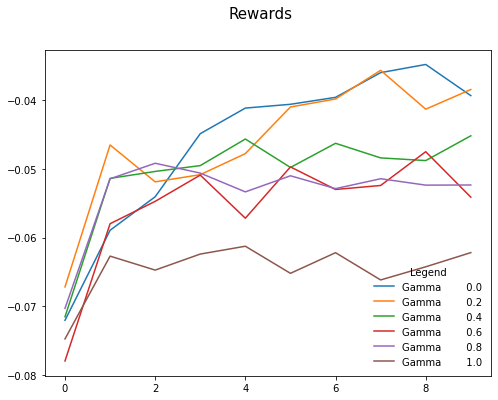

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(8, 6))
fig.suptitle('Rewards', fontsize=15)
for i in range(len(rewards_sarsa)):
    #print(i)
    ax.plot(rewards_sarsa[i], label="Gamma {:10.1f}".format((i*2)/10))
plt.legend(loc="lower right", title="Legend", frameon=False)
plt.show()

In [ ]:
rewards_sarsa_task1 = [
            [-0.07009, -0.06527, -0.06055, -0.06051, -0.06744, -0.06953, -0.05914, -0.06047, -0.05856, -0.05724],
            [-0.06272, -0.05656, -0.0559, -0.0532, -0.05553, -0.06841, -0.06213, -0.06631, -0.06202, -0.05126],
            [-0.08279, -0.07645, -0.07653, -0.07693, -0.07315, -0.07475, -0.0801, -0.07202, -0.08024, -0.08655],  
            [-0.10382, -0.11113, -0.11589, -0.11154, -0.11321, -0.1215, -0.12104, -0.1184, -0.11644, -0.12079],  
            [-0.12726, -0.14881, -0.15007, -0.1474, -0.15269, -0.1552, -0.1515, -0.15, -0.15445, -0.15269],  
            [-0.16104, -0.17309, -0.17258, -0.18122, -0.18352, -0.18219, -0.18175, -0.18328, -0.18081, -0.1806]
            ]

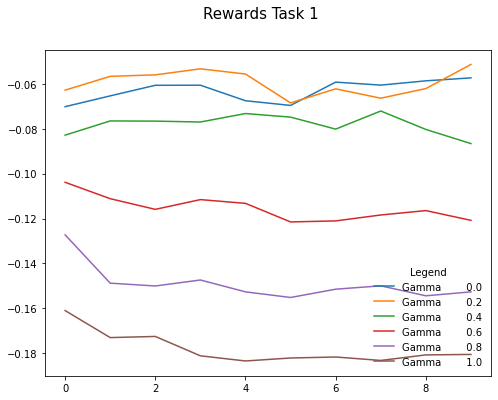

In [ ]:
fig, ax = plt.subplots(1, figsize=(8, 6))
fig.suptitle('Rewards Task 1', fontsize=15)
for i in range(len(rewards_sarsa_task1)):
    #print(i)
    ax.plot(rewards_sarsa_task1[i], label="Gamma {:10.1f}".format((i*2)/10))
plt.legend(loc="lower right", title="Legend", frameon=False)
plt.show()